In [2]:
#conda activate farm

import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torchvision import datasets, transforms

#import helper

import matplotlib.pyplot as plt


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
import os

print(os.getcwd())

os.chdir("Downloads")
print(os.getcwd())

/Users/robertbrown
/Users/robertbrown/Downloads


In [4]:
data_dir = 'train'


transform = transforms.Compose([
                                transforms.Scale((150,150)),
                                
                                transforms.ToTensor(), 
                               transforms.Normalize((0.5,), (0.5,)), 
                                
                               
                               ])

dataset = datasets.ImageFolder(data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

print(dataset.class_to_idx)

data_dir_test = 'test'

dataset = datasets.ImageFolder(data_dir_test, transform=transform)
testloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

data_dir_test = 'validation'

dataset = datasets.ImageFolder(data_dir_test, transform=transform)
validloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)



print(dataset.class_to_idx)


{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}
{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


/Users/robertbrown/opt/anaconda3/envs/farm/lib/python3.9/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 150, 150])

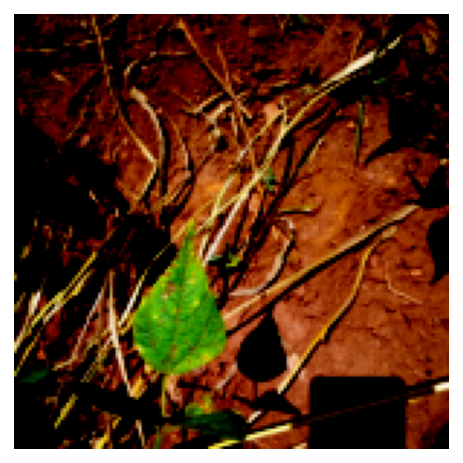

In [6]:
images, labels = next(iter(trainloader))
imshow(images[0], normalize=False)
images.shape

In [7]:
from torch import nn, optim
import torch.nn.functional as F

In [9]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*150*150,1000) #left number (input) l x w image size x 3 channels (RGB)
        self.fc2 = nn.Linear(1000,500)
        self.fc3 = nn.Linear(500,150 )
        self.fc4 = nn.Linear(150,75)
        self.conv2_drop = nn.Dropout2d()
        self.fc5 = nn.Linear(75, 30)
        self.fc_final = nn.Linear(30, 3) # number of classes (Bean)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc5(x))
        x = F.log_softmax(self.fc_final(x), dim=1)
        
        return x

In [10]:
# TODO: Create the network, define the criterion and optimizer

model = Classifier()
print(model)
#from opacus import PrivacyEngine
#privacy_engine = PrivacyEngine(
#    model,
#    sample_rate=0.01,
#    alphas=[10, 100],
#    noise_multiplier=1.1,
#    max_grad_norm=1.0,
#)


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#privacy_engine.attach(optimizer)

Classifier(
  (fc1): Linear(in_features=67500, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=75, bias=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc5): Linear(in_features=75, out_features=30, bias=True)
  (fc_final): Linear(in_features=30, out_features=3, bias=True)
)


In [ ]:
# TODO: Train the network here with validation 
epochs = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

In [ ]:
# Training with Validation
epochs = 10
min_valid_loss = np.inf

epoch_num = 0 

for e in range(epochs):
    epoch_num += 1
    train_loss = 0.0
    for data, labels in trainloader:
        if torch.cuda.is_available(): 
            data,labels = data.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        target = model(data)
        
        loss = criterion(target,labels)
        
        loss.backward()
        
        optimizer.step()
        
        
        
        train_loss += loss.item()
        
    valid_loss = 0.0
    for data, labels in validloader: 
        if torch.cuda.is_available(): 
            data,labels = data.cuda(), labels.cuda() 
            
        target = model(data )
        
        loss = criterion(target,labels)
        
        valid_loss += loss.item()
    print("Epoch", epoch_num)  
    print("Train Loss: ",train_loss/len(trainloader))
    print("Vaidation Loss: ", valid_loss/len(validloader))
        
        
    if min_valid_loss > valid_loss: 
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_model.pth')
        print("Model state updated. Best model so far at epoch: ", epoch_num)
        
            

Epoch 1
Train Loss:  0.8968670584938743
Vaidation Loss:  1.1908820986747741
Model state updated. Best model so far at epoch:  1
Epoch 2
Train Loss:  0.8860779169834021
Vaidation Loss:  1.0043790817260743
Model state updated. Best model so far at epoch:  2
Epoch 3
Train Loss:  0.8488443024230726
Vaidation Loss:  1.0593022227287292
Epoch 4
Train Loss:  0.8340782125790914
Vaidation Loss:  1.0534165501594543


In [12]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            #x = x.to(device=device)
            #y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [13]:
check_accuracy(trainloader,model)

Got 600 / 1034 with accuracy 58.03


In [41]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 100, 100])
torch.Size([32])


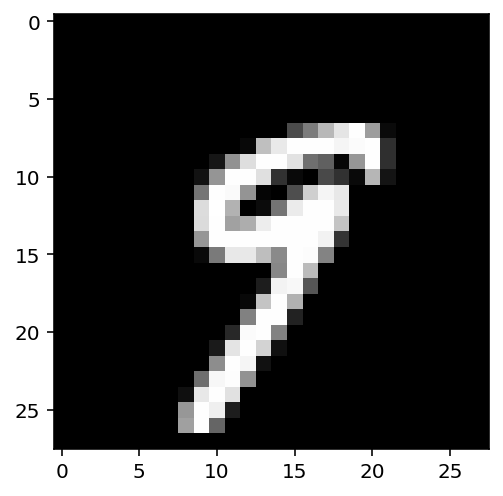

In [49]:
plt.imshow(images[9].numpy().squeeze(), cmap='Greys_r');

In [40]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [69]:
from opacus import PrivacyEngine

In [75]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


optimizer = optim.SGD(model.parameters(), lr=0.003)
#privacy_engine = PrivacyEngine(
#    model,
#    sample_rate=0.01,
#    alphas=[10, 100],
#    noise_multiplier=1.3,
#    max_grad_norm=1.0,
#)
#privacy_engine.attach(optimizer)

criterion = nn.NLLLoss()

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8062562604448689
Training loss: 0.8005575261263451
Training loss: 0.5235838822877483
Training loss: 0.42970325481662874
Training loss: 0.3840531589094001


In [73]:
%matplotlib inline
#import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    print(torch.exp(logps))
    

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)



tensor([[1.5805e-05, 3.6190e-05, 2.4327e-03, 5.9464e-04, 8.2723e-05, 3.3513e-03,
         1.1577e-04, 3.6572e-06, 9.9282e-01, 5.5081e-04]])


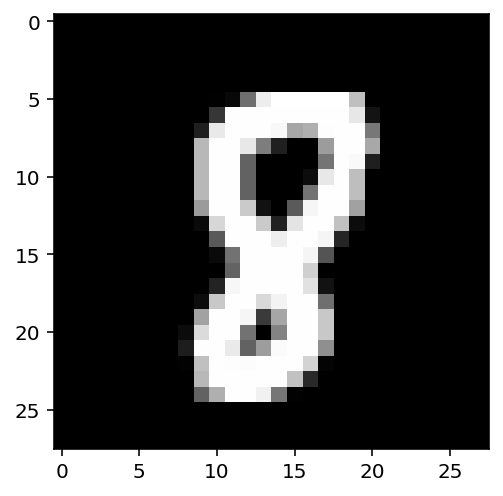

In [74]:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

In [64]:
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)